# Classification of a Signal that Produces Higgs Boson Particles and background signals
# Convolutional Neural Network
### Matthew Boyer and Jonah Goldfine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator,ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from skorch import NeuralNetBinaryClassifier
from skorch import callbacks as cb
import pickle

Loading best model from pickle file from the Optuna hyperparameter tuning.

In [2]:
studies_file='study.pkl'
best_model_file='best_model.pkl'
with open(studies_file,'rb') as file:
    studies=pickle.load(file)

c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
studies_df=studies.trials_dataframe().sort_values(by='value',ascending=False).head(1)
best_trial = studies_df.iloc[0]
best_trial

number                                         4
value                                   0.759064
datetime_start        2023-11-13 08:06:15.778856
datetime_complete     2023-11-13 10:42:27.524985
duration                  0 days 02:36:11.746129
params_activation                      LeakyReLU
params_batch_size                            200
params_layer_sizes                112_56_28_14_7
params_lr                                 0.0001
params_max_epochs                            250
state                                   COMPLETE
Name: 4, dtype: object

In [4]:

name_dtype=np.array([['class_label', np.float32], ['jet_1_b-tag', np.float64],
            ['jet_1_eta', np.float64], ['jet_1_phi', np.float64],
            ['jet_1_pt', np.float64], ['jet_2_b-tag', np.float64],
            ['jet_2_eta', np.float64], ['jet_2_phi', np.float64],
            ['jet_2_pt', np.float64], ['jet_3_b-tag', np.float64],
            ['jet_3_eta', np.float64], ['jet_3_phi', np.float64],
            ['jet_3_pt', np.float64], ['jet_4_b-tag', np.float64],
            ['jet_4_eta', np.float64], ['jet_4_phi', np.float64],
            ['jet_4_pt', np.float64], ['lepton_eta', np.float64],
            ['lepton_pT', np.float64], ['lepton_phi', np.float64],
            ['m_bb', np.float64], ['m_jj', np.float64],
            ['m_jjj', np.float64], ['m_jlv', np.float64],
            ['m_lv', np.float64], ['m_wbb', np.float64],
            ['m_wwbb', np.float64], ['missing_energy_magnitude', np.float64],
            ['missing_energy_phi', np.float64]])
fullData=pd.read_csv('HIGGS.csv',header=None,names=name_dtype[:,0])
unscaled_X=fullData.drop(['class_label'],axis=1)

In [5]:
categ_features = ['jet_3_b-tag', 'jet_4_b-tag', 'lepton_eta', 'm_jj']
num_features = unscaled_X.columns[~unscaled_X.columns.isin(categ_features)]
unscaled_X[['jet_3_b-tag', 'jet_4_b-tag', 'lepton_eta', 'm_jj']]

,jet_3_b-tag,jet_4_b-tag,lepton_eta,m_jj
0,0.000000,1.107436,0.000000,3.101961
1,2.173076,2.214872,0.000000,0.000000
2,0.000000,2.214872,2.548224,0.000000
3,0.000000,2.214872,0.000000,0.000000
4,0.000000,2.214872,0.000000,0.000000
...,...,...,...,...
10999995,0.000000,0.000000,0.000000,3.101961
10999996,2.173076,0.000000,0.000000,3.101961
10999997,2.173076,2.214872,0.000000,0.000000
10999998,0.000000,2.214872,0.000000,0.000000


These column seem to be categorical as they only have 3 different numbers for each column across the entire dataset. Then using Yeo-Johnson transformation, as it can normalize positive and negative numbers.

In [6]:
import scipy.stats as stats

for column in num_features:
    unscaled_X[column], fitted_lambda = stats.yeojohnson(unscaled_X[column])

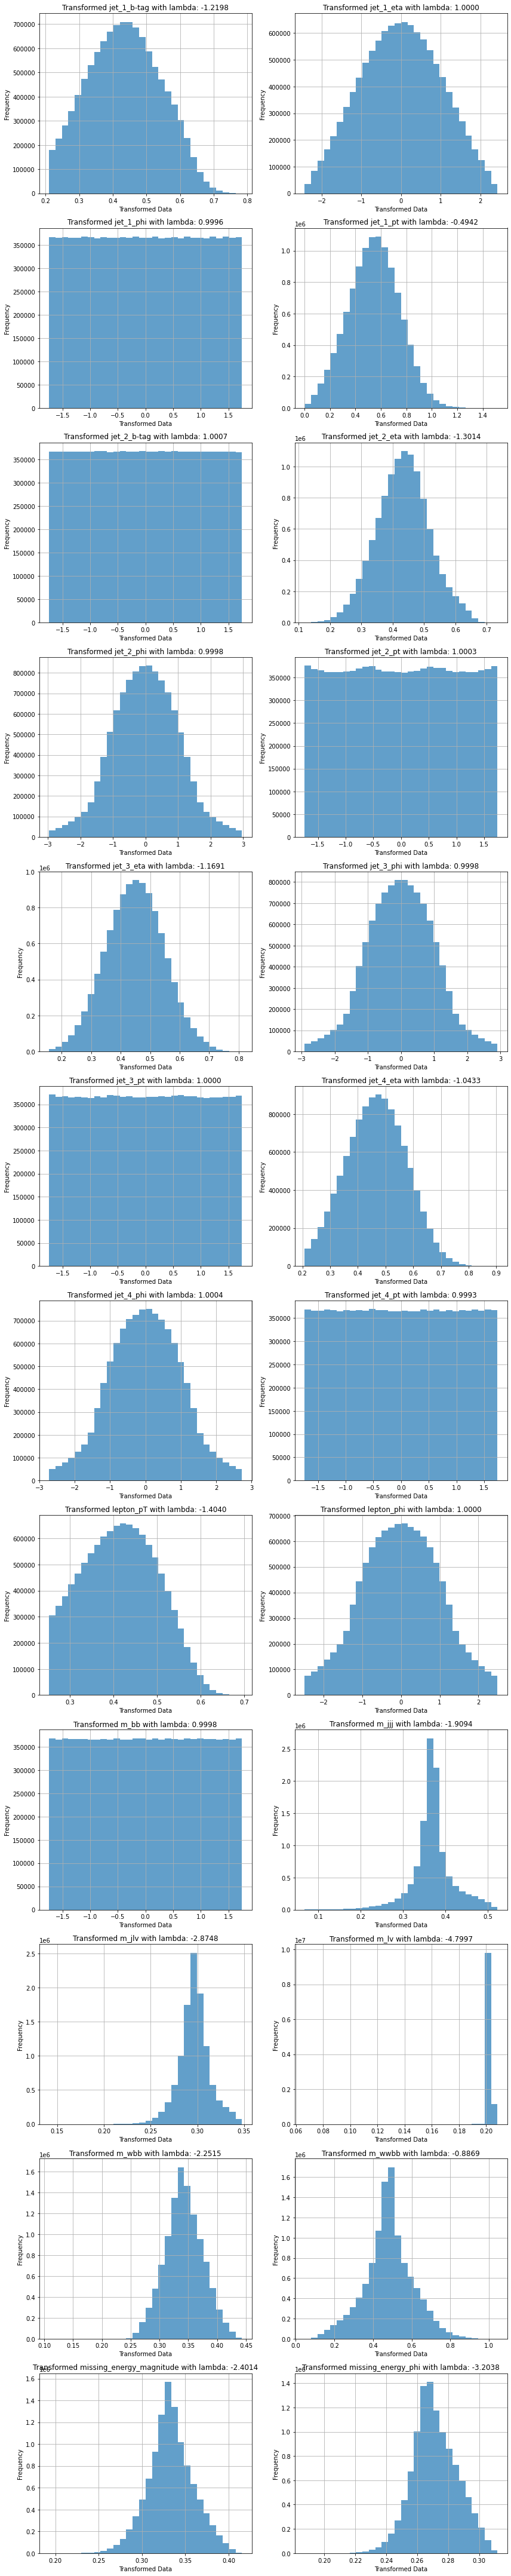

In [12]:
num_columns = len(num_features)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5*num_rows))  

for i, column in enumerate(num_features):
    row = i // 2
    col = i % 2
    
    axes[row, col].hist(unscaled_X[column], bins=30, alpha=0.7)
    axes[row, col].set_title(f'Transformed {column} with lambda: {fitted_lambda:.4f}')
    axes[row, col].set_xlabel('Transformed Data')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

In [7]:
scaler=StandardScaler()
norm_col = scaler.fit_transform(unscaled_X[num_features])
one_hot = pd.get_dummies(unscaled_X[categ_features].astype(str))
df = pd.DataFrame(norm_col, columns=num_features)
df = pd.concat([one_hot, df], axis=1)
df.head(5)

,jet_3_b-tag_0.0,jet_3_b-tag_1.0865380764007568,jet_3_b-tag_2.1730761528015137,jet_4_b-tag_0.0,jet_4_b-tag_1.1074360609054563,jet_4_b-tag_2.2148721218109126,lepton_eta_0.0,lepton_eta_1.2741122245788574,lepton_eta_2.548224449157715,m_jj_0.0,...,lepton_pT,lepton_phi,m_bb,m_jjj,m_jlv,m_lv,m_wbb,m_wwbb,missing_energy_magnitude,missing_energy_phi
0,1,0,0,0,1,0,1,0,0,0,...,-0.634425,-0.010358,-0.045404,1.064561,0.126241,-0.534207,-0.013868,-0.402035,0.122774,-0.061638
1,0,0,1,0,0,1,1,0,0,1,...,-1.743290,-1.130232,-0.000740,-3.402916,-0.611616,-0.446915,0.190051,-0.240768,0.136117,-0.482431
2,1,0,0,0,0,1,0,0,1,1,...,0.811105,1.120230,0.894760,0.019234,0.620455,-0.446999,0.098544,-0.178249,-0.385904,-0.591754
3,1,0,0,0,0,1,1,0,0,1,...,-0.348277,-0.673188,-1.351842,0.133202,0.329243,-0.302941,-0.853484,-0.010873,0.259354,0.303283
4,1,0,0,0,0,1,1,0,0,1,...,-1.345102,-0.370698,0.112398,-0.533463,1.311710,-0.436624,-0.337931,0.561024,-0.356921,-0.423574


In [8]:
full_y=fullData['class_label']
X_train_df,X_test_df,y_train_df,y_test_df=train_test_split(df,full_y,test_size=0.8,random_state=0)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_df, y_train_df)

knn_predict = knn.predict(X_test_df)
knn_predict_train = knn.predict(X_train_df)

knn_score_train = accuracy_score(y_train_df, knn_predict_train)
print(f'Train KNN accuracy: {knn_score_train:.3f}')
knn_score = accuracy_score(y_test_df, knn_predict)
print(f'Test KNN accuracy: {knn_score:.3f}')

c:\Python39\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Python39\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Train KNN accuracy: 0.823
Test KNN accuracy: 0.621


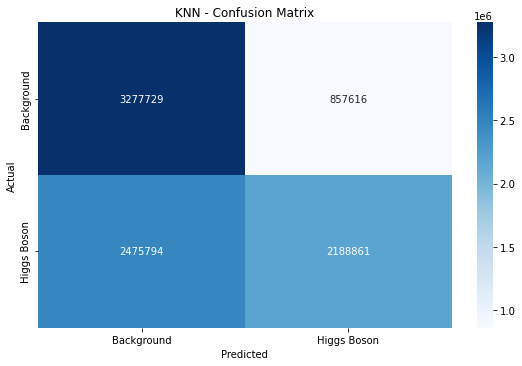

In [17]:
cm=confusion_matrix(y_test_df,knn_predict)
plt.figure(figsize=(9.26,5.62))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['Background','Higgs Boson'],yticklabels=['Background','Higgs Boson'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('KNN - Confusion Matrix')
plt.show()

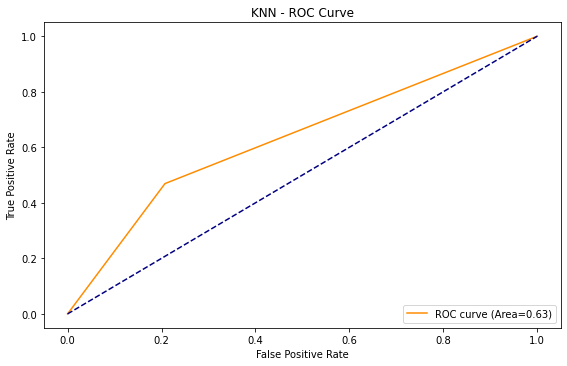

In [19]:
fpr,tpr,_=roc_curve(y_test_df,knn_predict)
auc_sc=auc(fpr,tpr)

plt.figure(figsize=(9.26,5.62))
plt.plot(fpr,tpr,color='darkorange',label=f'ROC curve (Area={auc_sc:.2f})')
plt.plot([0,1],[0,1],color='navy',linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN - ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [9]:
X_train=torch.tensor(X_train_df.values).float()
X_test=torch.tensor(X_test_df.values).float()
y_train=torch.tensor(y_train_df.values).float()
y_test=torch.tensor(y_test_df.values).float()

In [21]:
nn.ModuleList()

ModuleList()

## DNNs

Training 3 different DNN models. One with Dropout and LeakyReLu activation, one without Dropout and LeakyReLu activation, and one with Dropout and Tanh activation.

In [10]:
class DNN_Drop(nn.Module):
    def __init__(self, layer_sizes):
        super(DNN_Drop, self).__init__()
        self.layers=nn.ModuleList()
        activation = nn.LeakyReLU()
        # This is here because in Optuna you can only send lists of strings, not lists of lists. So we split the string to get the layer sizes.
        if layer_sizes == 'empty':
            layer_sizes = []
        else:
            layer_sizes = [int(size) for size in layer_sizes.split('_')]
        
        if len(layer_sizes)==0:
            self.layers.append(nn.Linear(36,1))
            self.layers.append(nn.Sigmoid())
        else:
            for i, hidden_size in enumerate(layer_sizes):
                if i==0:
                    self.layers.append(nn.Linear(36,hidden_size))
                    self.layers.append(nn.Dropout(p=0.25))
                    self.layers.append(activation)
                    input_size=hidden_size
                else:
                    self.layers.append(nn.Linear(input_size,hidden_size))
                    self.layers.append(activation)
                    input_size=hidden_size
            self.layers.append(nn.Linear(input_size,1))
            self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.squeeze()

In [11]:
DNN_Drop_model=NeuralNetBinaryClassifier(
    DNN_Drop,
    module__layer_sizes=best_trial['params_layer_sizes'],
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    optimizer__lr=best_trial['params_lr'],
    max_epochs=int(best_trial['params_max_epochs']),
    batch_size= int(best_trial['params_batch_size']),
    callbacks=[('early_stopping',cb.EarlyStopping(patience=10)), 
               ('train_acc',cb.EpochScoring(scoring='accuracy',
                                            lower_is_better=False,
                                            on_train=True))],
    verbose=5,
    threshold=0.525
)

In [12]:
DNN_Drop_model.fit(X_train, y_train)

  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.6728        0.6006       0.7100        0.5603  48.4227
      2      0.7061        0.5643       0.7214        0.5438  48.4777
      3      0.7157        0.5504       0.7278        0.5329  48.1945
      4      0.7218        0.5408       0.7324        0.5253  48.3131
      5      0.7257        0.5349       0.7353        0.5206  48.2053
      6      0.7285        0.5306       0.7377        0.5168  48.2286
      7      0.7304        0.5278       0.7392        0.5142  48.0651
      8      0.7321        0.5253       0.7411        0.5121  48.2584
      9      0.7328        0.5237       0.7423        0.5104  47.9619
     10      0.7346        0.5219       0.7432        0.5088  48.0726
     11      0.7353        0.5202       0.7440        0.5073  48.5125
     12      0.7361        0.5191       0.7446        0.5064  48.3082
     13      0.7370 

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=DNN_Drop(
    (layers): ModuleList(
      (0): Linear(in_features=36, out_features=112, bias=True)
      (1): Dropout(p=0.25, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=112, out_features=56, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Linear(in_features=56, out_features=28, bias=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Linear(in_features=28, out_features=14, bias=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Linear(in_features=14, out_features=7, bias=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Linear(in_features=7, out_features=1, bias=True)
      (12): Sigmoid()
    )
  ),
)

In [25]:
class DNN_No_Drop(nn.Module):
    def __init__(self, layer_sizes):
        super(DNN_No_Drop, self).__init__()
        self.layers=nn.ModuleList()
        activation = nn.LeakyReLU()
        if layer_sizes == 'empty':
            layer_sizes = []
        else:
            layer_sizes = [int(size) for size in layer_sizes.split('_')]
        
        if len(layer_sizes)==0:
            self.layers.append(nn.Linear(36,1))
            self.layers.append(nn.Sigmoid())
        else:
            for i, hidden_size in enumerate(layer_sizes):
                if i==0:
                    self.layers.append(nn.Linear(36,hidden_size))
                    self.layers.append(activation)
                    input_size=hidden_size
                else:
                    self.layers.append(nn.Linear(input_size,hidden_size))
                    self.layers.append(activation)
                    input_size=hidden_size
            self.layers.append(nn.Linear(input_size,1))
            self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.squeeze()

In [26]:
DNN_No_Drop_model=NeuralNetBinaryClassifier(
    DNN_No_Drop,
    module__layer_sizes=best_trial['params_layer_sizes'],
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    optimizer__lr=best_trial['params_lr'],
    max_epochs=int(best_trial['params_max_epochs']),
    batch_size= int(best_trial['params_batch_size']),
    callbacks=[('early_stopping',cb.EarlyStopping(patience=10)), 
               ('train_acc',cb.EpochScoring(scoring='accuracy',
                                            lower_is_better=False,
                                            on_train=True))],
    verbose=5,
    threshold=0.525
)

In [27]:
DNN_No_Drop_model.fit(X_train, y_train)

  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.6889        0.5825       0.7131        0.5540  45.9063
      2      0.7182        0.5468       0.7230        0.5385  46.3394
      3      0.7259        0.5343       0.7288        0.5288  46.3844
      4      0.7312        0.5259       0.7329        0.5221  46.2294
      5      0.7350        0.5204       0.7359        0.5178  46.1934
      6      0.7374        0.5166       0.7382        0.5147  46.1024
      7      0.7395        0.5138       0.7394        0.5122  46.4174
      8      0.7411        0.5113       0.7408        0.5100  46.4164
      9      0.7426        0.5091       0.7421        0.5081  46.1504
     10      0.7439        0.5072       0.7432        0.5065  46.6415
     11      0.7450        0.5056       0.7443        0.5051  46.0674
     12      0.7459        0.5042       0.7451        0.5039  46.4184
     13      0.7469 

In [ ]:
class DNN_Drop_Tanh(nn.Module):
    def __init__(self, layer_sizes):
        super(DNN_Drop_Tanh, self).__init__()
        self.layers=nn.ModuleList()
        activation = nn.Tanh()
        if layer_sizes == 'empty':
            layer_sizes = []
        else:
            layer_sizes = [int(size) for size in layer_sizes.split('_')]
        
        if len(layer_sizes)==0:
            self.layers.append(nn.Linear(36,1))
            self.layers.append(nn.Sigmoid())
        else:
            for i, hidden_size in enumerate(layer_sizes):
                if i==0:
                    self.layers.append(nn.Linear(36,hidden_size))
                    self.layers.append(nn.Dropout(p=0.25))
                    self.layers.append(activation)
                    input_size=hidden_size
                else:
                    self.layers.append(nn.Linear(input_size,hidden_size))
                    self.layers.append(activation)
                    input_size=hidden_size
            self.layers.append(nn.Linear(input_size,1))
            self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.squeeze()

In [ ]:
DNN_Drop_Tanh_model=NeuralNetBinaryClassifier(
    DNN_Drop_Tanh,
    module__layer_sizes=best_trial['params_layer_sizes'],
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    optimizer__lr=best_trial['params_lr'],
    max_epochs=int(best_trial['params_max_epochs']),
    batch_size= int(best_trial['params_batch_size']),
    callbacks=[('early_stopping',cb.EarlyStopping(patience=10)), 
               ('train_acc',cb.EpochScoring(scoring='accuracy',
                                            lower_is_better=False,
                                            on_train=True))],
    verbose=5
)

DNN_Drop_Tanh_model.fit(X_train, y_train)

  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.6524        0.6200       0.6901        0.5828  43.2982
      2      0.6934        0.5791       0.7079        0.5610  43.2725
      3      0.7058        0.5634       0.7171        0.5486  42.5536
      4      0.7136        0.5528       0.7224        0.5404  42.4893
      5      0.7191        0.5456       0.7276        0.5334  43.0775
      6      0.7234        0.5396       0.7309        0.5282  43.8563
      7      0.7268        0.5355       0.7335        0.5248  43.2018
      8      0.7285        0.5326       0.7349        0.5223  43.5530
      9      0.7300        0.5302       0.7363        0.5202  42.9380
     10      0.7310        0.5286       0.7375        0.5182  42.5984
     11      0.7322        0.5267       0.7381        0.5167  42.9491
     12      0.7333        0.5251       0.7398        0.5148  43.2430
     13      0.7342 

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=DNN_Drop_Tanh(
    (layers): ModuleList(
      (0): Linear(in_features=28, out_features=112, bias=True)
      (1): Dropout(p=0.25, inplace=False)
      (2): Tanh()
      (3): Linear(in_features=112, out_features=56, bias=True)
      (4): Tanh()
      (5): Linear(in_features=56, out_features=28, bias=True)
      (6): Tanh()
      (7): Linear(in_features=28, out_features=14, bias=True)
      (8): Tanh()
      (9): Linear(in_features=14, out_features=7, bias=True)
      (10): Tanh()
      (11): Linear(in_features=7, out_features=1, bias=True)
      (12): Sigmoid()
    )
  ),
)

In [ ]:
y_pred_tanh = DNN_Drop_Tanh_model.predict(X_test)

Using prediction to calculate class-wise accuracy.

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_tanh)
tn, fp, fn, tp = cm.ravel()

# Class-wise accuracy
accuracy_0_tanh = tn / (tn + fp)
accuracy_1_tanh = tp / (tp + fn)

print("Accuracy for class 0:", accuracy_0_tanh)
print("Accuracy for class 1:", accuracy_1_tanh)

Accuracy for class 0: 0.73659102203081
Accuracy for class 1: 0.7750671807454141


In [14]:
y_pred_drop = DNN_Drop_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_drop)
tn, fp, fn, tp = cm.ravel()

# Class-wise accuracy
accuracy_0_drop = tn / (tn + fp)
accuracy_1_drop = tp / (tp + fn)

print("Accuracy for class 0:", accuracy_0_drop)
print("Accuracy for class 1:", accuracy_1_drop)

Accuracy for class 0: 0.7181775643870101
Accuracy for class 1: 0.7920073403070538


In [ ]:
y_pred_nodrop = DNN_No_Drop_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_nodrop)
tn, fp, fn, tp = cm.ravel()

# Class-wise accuracy
accuracy_0_nodrop = tn / (tn + fp)
accuracy_1_nodrop = tp / (tp + fn)

print("Accuracy for class 0:", accuracy_0_nodrop)
print("Accuracy for class 1:", accuracy_1_nodrop)

Accuracy for class 0: 0.7665877937632773
Accuracy for class 1: 0.7570540586602867


In [15]:
y_proba_drop = DNN_Drop_model.predict_proba(X_test)[:, 1]  

In [ ]:
y_proba_nodrop = DNN_No_Drop_model.predict_proba(X_test)[:, 1]
y_proba_tanh = DNN_Drop_Tanh_model.predict_proba(X_test)[:, 1] 

This section is purely for creating csvs for graph creation.

In [18]:
def Get_Metrics(model_name,model_history):
    epoch_training_losses = model_history[:, 'train_loss']
    epoch_validation_losses = model_history[:, 'valid_loss']
    epoch_training_accuracies = model_history[:, 'accuracy']
    epoch_validation_accuracies = model_history[:, 'valid_acc']
    epochs = model_history[:, 'epoch']
    # Models sometimes have one less accuracy
    if model_name == 'Tanh w/ Drop' or model_name == 'LeakyReLu w/ Drop':
        epoch_training_accuracies.insert(0,0)

    return pd.DataFrame({
    'epoch': epochs,
    'model': [model_name for _ in epoch_training_losses],
    'training_loss': epoch_training_losses,
    'validation_loss': epoch_validation_losses,
    'training_accuracy': epoch_training_accuracies,
    'validation_accuracy': epoch_validation_accuracies
    })

# Create a DataFrame for aggregated epoch metrics
metrics_df = Get_Metrics('LeakyReLu w/ Drop', DNN_Drop_model.history)
#metrics_df = pd.concat([metrics_df, Get_Metrics('Tanh w/ Drop', DNN_Drop_Tanh_model.history)])

In [19]:
class_wise_acc = pd.DataFrame({
    'model': 'LeakyReLu w/ Drop',
    'accuracy0': [accuracy_0_drop],
    'accuracy1': [accuracy_1_drop],
})

#class_wise_acc = pd.concat([class_wise_acc, pd.DataFrame({
#    'model': 'LeakyReLu w/o Drop',
#     'accuracy0': [accuracy_0_nodrop],
#     'accuracy1': [accuracy_1_nodrop]
# })])

# class_wise_acc = pd.concat([class_wise_acc,  pd.DataFrame({
#     'model': 'Tanh w/ Drop',
#     'accuracy0': [accuracy_0_tanh],
#     'accuracy1': [accuracy_1_tanh]
# })])

In [ ]:
results_df = pd.DataFrame({'model': 'LeakyReLu w/ Drop','y_test': y_test, 'y_predictions': y_pred_drop, 'y_proba': y_proba_drop})
#results_df = pd.concat([results_df, pd.DataFrame({'model': 'LeakyReLu w/o Drop','y_test': y_test, 'y_predictions': y_pred_nodrop, 'y_proba': y_proba_nodrop})])
#results_df = pd.concat([results_df, pd.DataFrame({'model': 'Tanh w/ Drop','y_test': y_test, 'y_predictions': y_pred_tanh, 'y_proba': y_proba_tanh})])

# Exporting results
results_df.to_csv('drop_results.csv', index=False)

# Exporting metrics
metrics_df.to_csv('drop_metrics.csv', index=False)

In [ ]:
# Exporting class accuracies
class_wise_acc.to_csv('drop_class_acc.csv', index=False)